# **Marketing Econometrics**
----------------------------
### **Project 2 - Building a performant propensity score model**

Our goal is to predict if a customer is going to repurchase on the next month and make recommendations to the marketing department on how to use these predictions for their marketing campaign.


    Member: AMANI ALEXANDRA
            BECQUART COLOMBE
            SALIOU APOLLINE
    Date:   06/12/2021

In [ ]:
import numpy as np
import pandas as pd

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# XGBoost
import xgboost as xgb
from  xgboost import XGBClassifier

# sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
!pip install scikit-plot
import scikitplot as skplt

In [ ]:
pd.set_option('display.max_columns', 100)

# **Step 1 Data understanding**

#### **1 . Loading the data sets**

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Train set with potential covariates and repuchase dummy
TRAIN_TRANSACTIONS = pd.read_csv("/content/drive/MyDrive/Marketing2/Train_transactions.csv")
TRAIN_REPURCHASE = pd.read_csv("/content/drive/MyDrive/Marketing2/Train_customers_repurchase.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Test set with covarites
TEST = pd.read_csv("/content/drive/MyDrive/Marketing2/Test_transactions.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### **2. Understanding the TRAIN_TRANSACTIONS and TRAIN_REPURCHASE**


In [ ]:
print(TRAIN_TRANSACTIONS.shape)
TRAIN_TRANSACTIONS.head()

(3298736, 17)


,id_client,transaction_date,stores_nb,item_count,gross_amount,discount_amount,basket_value,payment_gift,payment_cheque,payment_cash,payment_card,email_domain,civility,zip_code,card_subscription,multicard,price_segmentation
0,37520523,2019-12-26T16:44:00.000Z,12015,57,138.69,0.49,138.20,0,0,1,0,NaN,MME,12420,NaN,0.0,NaN
1,84917629,2019-08-01T12:16:00.000Z,77131,6,9.87,0.00,9.87,0,0,1,0,NaN,MME,77450,NaN,0.0,NaN
2,20962900,2019-09-25T18:10:00.000Z,92786,6,26.25,2.21,24.04,0,0,0,1,GMAIL.COM,MME,92110,NaN,0.0,Quali
3,85917543,2020-01-24T17:34:00.000Z,21554,5,15.08,0.00,15.08,0,0,0,1,SFR.FR,M,21130,NaN,0.0,Mixte
4,6861392,2019-08-22T19:28:00.000Z,83820,25,81.16,30.60,50.56,0,0,0,1,ORANGE.FR,MME,83600,NaN,0.0,Mixte


In [ ]:
TRAIN_TRANSACTIONS.dtypes

id_client               int64
transaction_date       object
stores_nb               int64
item_count              int64
gross_amount          float64
discount_amount       float64
basket_value          float64
payment_gift            int64
payment_cheque          int64
payment_cash            int64
payment_card            int64
email_domain           object
civility               object
zip_code               object
card_subscription      object
multicard             float64
price_segmentation     object
dtype: object

In [ ]:
TRAIN_TRANSACTIONS.describe()

,id_client,stores_nb,item_count,gross_amount,discount_amount,basket_value,payment_gift,payment_cheque,payment_cash,payment_card,multicard
count,3.298736e+06,3.298736e+06,3.298736e+06,3.298736e+06,3.298736e+06,3.298736e+06,3.298736e+06,3.298736e+06,3.298736e+06,3.298736e+06,3.292217e+06
mean,3.531360e+07,4.467323e+04,1.598724e+01,5.057524e+01,3.494432e+00,4.708081e+01,6.917104e-02,3.350435e-02,2.269836e-01,6.780846e-01,6.233611e-02
std,2.817260e+07,2.842219e+04,1.733723e+01,6.290823e+01,1.062924e+01,5.673420e+01,2.537448e-01,1.799495e-01,4.188820e-01,4.672108e-01,2.531078e-01
min,2.910000e+02,1.238000e+03,-2.880000e+02,-2.602980e+03,-1.131970e+03,-2.342680e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.172922e+07,2.000100e+04,5.000000e+00,1.323000e+01,0.000000e+00,1.291000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.167772e+07,3.820600e+04,1.000000e+01,3.024000e+01,0.000000e+00,2.919000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,3.850131e+07,7.334200e+04,2.100000e+01,6.783000e+01,2.250000e+00,6.227000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,8.801040e+07,9.963400e+04,2.159000e+03,2.306485e+04,2.837370e+03,2.022748e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.100000e+01


In [ ]:
# If we take a client, what can we observe? 
TRAIN_TRANSACTIONS[TRAIN_TRANSACTIONS.id_client == 37520523]

,id_client,transaction_date,stores_nb,item_count,gross_amount,discount_amount,basket_value,payment_gift,payment_cheque,payment_cash,payment_card,email_domain,civility,zip_code,card_subscription,multicard,price_segmentation
0,37520523,2019-12-26T16:44:00.000Z,12015,57,138.69,0.49,138.20,0,0,1,0,NaN,MME,12420,NaN,0.0,NaN
224222,37520523,2019-12-28T12:21:00.000Z,12015,14,41.48,0.00,41.48,0,0,0,1,NaN,MME,12420,NaN,0.0,NaN
1410126,37520523,2019-08-12T17:04:00.000Z,12015,39,106.46,0.00,106.46,0,0,1,0,NaN,MME,12420,NaN,0.0,NaN
1840321,37520523,2019-08-26T18:24:00.000Z,12015,24,83.80,0.00,83.80,0,0,0,1,NaN,MME,12420,NaN,0.0,NaN
2851667,37520523,2019-12-31T14:17:00.000Z,12015,12,60.62,8.00,52.62,0,0,0,1,NaN,MME,12420,NaN,0.0,NaN


In [ ]:
# Number of clients
TRAIN_TRANSACTIONS.groupby(['id_client']).count()

,transaction_date,stores_nb,item_count,gross_amount,discount_amount,basket_value,payment_gift,payment_cheque,payment_cash,payment_card,email_domain,civility,zip_code,card_subscription,multicard,price_segmentation
id_client,,,,,,,,,,,,,,,,
291,55,55,55,55,55,55,55,55,55,55,0,55,55,0,55,55
365,25,25,25,25,25,25,25,25,25,25,25,25,25,0,25,25
1800,78,78,78,78,78,78,78,78,78,78,78,78,78,0,78,78
3471,60,60,60,60,60,60,60,60,60,60,0,60,60,0,60,60
3961,3,3,3,3,3,3,3,3,3,3,3,3,3,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88009509,7,7,7,7,7,7,7,7,7,7,7,7,7,0,7,0
88010247,5,5,5,5,5,5,5,5,5,5,0,5,5,0,5,5
88010368,11,11,11,11,11,11,11,11,11,11,0,11,11,0,11,11


There are 160424 clients.

In [ ]:
print(TRAIN_TRANSACTIONS["transaction_date"].min())
print(TRAIN_TRANSACTIONS["transaction_date"].max())

2019-08-01T00:23:00.000Z
2020-07-31T23:55:00.000Z


We have the data of clients from 2019-08-01 to 2020-07-31. The month 2020-08 has been removed from this dataset.

In [ ]:
print(TRAIN_REPURCHASE.shape)
TRAIN_REPURCHASE.head()

,id_client,repurchase
0,87960418,1
1,2279977,1
2,3693324,1
3,3455547,1
4,37894758,1


In [ ]:
TRAIN_REPURCHASE.mean()

id_client     3.751464e+07
repurchase    7.724530e-02
dtype: float64

7% of clients buy the next month

**Missing values in the data frame**

Number of missing values per column : missing values in email_domain, civility, zip_code, card_subscription, multicard and price_segmentation.

In [ ]:
TRAIN_TRANSACTIONS.isna().sum()

id_client                   0
transaction_date            0
stores_nb                   0
item_count                  0
gross_amount                0
discount_amount             0
basket_value                0
payment_gift                0
payment_cheque              0
payment_cash                0
payment_card                0
email_domain          1281508
civility                 6519
zip_code               304508
card_subscription     3082597
multicard                6519
price_segmentation    1563053
dtype: int64

In [ ]:
TRAIN_REPURCHASE.isna().sum()

id_client     0
repurchase    0
dtype: int64

#### **3. Understanding TEST_TRANSACTIONS data set**

In [ ]:
TEST.head()

,id_client,transaction_date,stores_nb,item_count,gross_amount,discount_amount,basket_value,payment_gift,payment_cheque,payment_cash,payment_card,email_domain,civility,zip_code,card_subscription,multicard,price_segmentation
0,28786736,2019-12-06T11:26:00.000Z,31906,24,35.08,0.0,35.08,0,1,0,0,NaN,MME,31200,NaN,0.0,Access
1,15243133,2020-03-09T12:21:00.000Z,38579,5,7.90,0.0,7.90,0,0,0,1,FREE.FR,MME,38360,NaN,0.0,Mixte
2,83947833,2019-12-11T09:46:00.000Z,19330,8,22.86,0.0,22.86,0,0,1,0,ORANGE.FR,MME,19100,NaN,0.0,Access
3,16108194,2019-08-24T19:04:00.000Z,69130,2,10.99,0.0,10.99,0,0,0,1,NaN,MME,69003,NaN,0.0,Quali
4,7619400,2020-03-25T09:50:00.000Z,38990,10,32.42,0.0,32.42,0,0,0,1,NaN,MME,38100,NaN,0.0,Quali


In [ ]:
TEST.describe()

,id_client,stores_nb,item_count,gross_amount,discount_amount,basket_value,payment_gift,payment_cheque,payment_cash,payment_card,multicard
count,8.242820e+05,824282.000000,824282.000000,824282.000000,824282.000000,824282.000000,824282.000000,824282.000000,824282.000000,824282.000000,823179.000000
mean,3.517420e+07,44651.901275,15.911962,50.468670,3.495333,46.973336,0.069378,0.032983,0.228843,0.681876,0.065048
std,2.813486e+07,28335.870843,17.628241,61.980089,11.149363,55.556644,0.254096,0.178591,0.420088,0.465748,0.246610
min,2.098000e+03,1238.000000,-116.000000,-999.000000,-260.480000,-899.100000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.165568e+07,20001.000000,5.000000,13.290000,0.000000,12.990000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.159578e+07,38206.000000,10.000000,30.140000,0.000000,29.120000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3.850701e+07,73342.000000,21.000000,67.390000,2.170000,61.887500,0.000000,0.000000,0.000000,1.000000,0.000000
max,8.801038e+07,99634.000000,3600.000000,7718.400000,3087.360000,6425.460000,1.000000,1.000000,1.000000,1.000000,1.000000


The distributions are similar in TEST and in TRAIN_TRANSACTIONS.

In [ ]:
# Number of clients
TEST.groupby(['id_client']).count()

,transaction_date,stores_nb,item_count,gross_amount,discount_amount,basket_value,payment_gift,payment_cheque,payment_cash,payment_card,email_domain,civility,zip_code,card_subscription,multicard,price_segmentation
id_client,,,,,,,,,,,,,,,,
2098,36,36,36,36,36,36,36,36,36,36,0,36,36,0,36,36
3399,103,103,103,103,103,103,103,103,103,103,0,103,103,0,103,103
3712,80,80,80,80,80,80,80,80,80,80,80,80,80,0,80,80
4664,51,51,51,51,51,51,51,51,51,51,0,51,51,0,51,51
6741,17,17,17,17,17,17,17,17,17,17,0,17,17,0,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88008276,2,2,2,2,2,2,2,2,2,2,0,2,2,0,2,2
88009039,14,14,14,14,14,14,14,14,14,14,0,14,14,0,14,0
88010326,15,15,15,15,15,15,15,15,15,15,0,15,15,0,15,0


There are 40106 clients.

In [ ]:
print(TEST["transaction_date"].min())
print(TEST["transaction_date"].max())

2019-08-01T07:55:00.000Z
2020-07-31T23:42:00.000Z


We have the data of clients from 2019-08-01 to 2020-07-31. The month 2020-08 has been removed from this dataset.

In [ ]:
TEST.isna().sum()

id_client                  0
transaction_date           0
stores_nb                  0
item_count                 0
gross_amount               0
discount_amount            0
basket_value               0
payment_gift               0
payment_cheque             0
payment_cash               0
payment_card               0
email_domain          319811
civility                1103
zip_code               74180
card_subscription     770467
multicard               1103
price_segmentation    388422
dtype: int64

The varaibles with missing values in the TEST dataframe are the same as the ones with missig values in TRAIN_TRANSACTIONS.

# **Step 2 : Data preparation**


#### **1. Preparation of the covariates of the training set**
We build a table at the client level from TRAIN_TRANSACTION. We choose relevant features and clean the data set.

In [ ]:
# Transformation of the date of transaction in the date format

TRAIN_TRANSACTIONS["transaction_date"] = TRAIN_TRANSACTIONS["transaction_date"].apply(lambda x: x[0:-14])
TRAIN_TRANSACTIONS["transaction_date"] = pd.to_datetime(TRAIN_TRANSACTIONS["transaction_date"])

In [ ]:
# Creation of the maximum and minimum dates 

min_date = TRAIN_TRANSACTIONS["transaction_date"].min()
max_date = TRAIN_TRANSACTIONS["transaction_date"].max()
print(min_date)
print(max_date)

# Creation of the maximum date excluding the last month
date_last_month = '2020-05-31'

2019-08-01 00:00:00
2020-07-31 00:00:00


In [ ]:
# Aggrating the transactions at the client level and obtaining relevant indicators about the frequency of behaviours
agg_dict = {"transaction_date": ["count"],
            'item_count': ['sum'],
            "gross_amount": ['sum'],
            "discount_amount": ['sum'],
            "stores_nb": ['count'],
            "payment_gift": ['mean'],
            "payment_card": ['mean'],
            "payment_cash": ['mean']
           }

col_list = ['id_client','nb_visit','cumul_item',
                     'cumul_gross_amount', 'cumul_discount_amount',
                     'nb_store', 'gift', 'card', 'cash']

FREQUENCY_TRAIN = TRAIN_TRANSACTIONS.groupby('id_client').aggregate(
    agg_dict, drop_index=True).reset_index()

FREQUENCY_TRAIN.columns = col_list

In [ ]:
# Repeat the last step focusing on the last two months

# Subset
TRAIN_TRANSACTIONS_LAST_2M = TRAIN_TRANSACTIONS[TRAIN_TRANSACTIONS.transaction_date > date_last_month]

# Aggregate
agg_dict_last_2m = {"transaction_date": ["count"],
            'item_count': ['sum'],
            "gross_amount": ['sum'],
            "discount_amount": ['sum']}

col_list_last_2m = ['id_client','nb_visit_2m','cumul_item_2m',
                     'cumul_gross_amount_2m', 'cumul_discount_amount_2m']

FREQUENCY_TRAIN_LAST_2M = TRAIN_TRANSACTIONS_LAST_2M.groupby('id_client').aggregate(
    agg_dict_last_2m, drop_index=True).reset_index()

FREQUENCY_TRAIN_LAST_2M.columns = col_list_last_2m

In [ ]:
# Recency is in days and separates the last visit to the 31 july 2020
RECENCY_TRAIN = TRAIN_TRANSACTIONS.groupby('id_client').aggregate(
    {'transaction_date': ['max']}).reset_index()

RECENCY_TRAIN.columns = ['id_client', 'last_date']
RECENCY_TRAIN["recency"] = (max_date - RECENCY_TRAIN['last_date'])/np.timedelta64(1, 'D')


We can now create the table with the covariates of the training set:

In [ ]:
# Merge the different tables with aggregated values at the client level
X_TRAIN = FREQUENCY_TRAIN.merge(RECENCY_TRAIN[['id_client','recency']], on ="id_client", how= "left")
X_TRAIN = X_TRAIN.merge(FREQUENCY_TRAIN_LAST_2M, on ="id_client", how= "left")
X_TRAIN.head()

,id_client,nb_visit,cumul_item,cumul_gross_amount,cumul_discount_amount,nb_store,gift,card,cash,recency,nb_visit_2m,cumul_item_2m,cumul_gross_amount_2m,cumul_discount_amount_2m
0,291,55,1499,4151.43,119.99,55,0.090909,1.000000,0.000000,0.0,9.0,231.0,638.07,3.66
1,365,25,140,390.05,1.97,25,0.040000,0.560000,0.440000,52.0,1.0,13.0,36.31,0.00
2,1800,78,1961,7900.33,879.23,78,0.269231,0.961538,0.038462,6.0,17.0,383.0,1745.92,186.05
3,3471,60,406,1203.76,8.53,60,0.000000,0.116667,0.883333,139.0,NaN,NaN,NaN,NaN
4,3961,3,131,415.34,1.62,3,0.000000,0.666667,0.333333,310.0,NaN,NaN,NaN,NaN


There are some missing values from the table FREQUENCY_TRAIN_LAST_2M because some people did not buy anything during this period. We can replace the missing values by 0: the number of time they came, the number of items they bought or the amount spend is indeed 0 for them. 

In [ ]:
# Replace NA by 0
X_TRAIN.isna().sum()
X_TRAIN = X_TRAIN.fillna(0)

# Ckeck there are no more NA
X_TRAIN.isna().sum()

id_client                   0
nb_visit                    0
cumul_item                  0
cumul_gross_amount          0
cumul_discount_amount       0
nb_store                    0
gift                        0
card                        0
cash                        0
recency                     0
nb_visit_2m                 0
cumul_item_2m               0
cumul_gross_amount_2m       0
cumul_discount_amount_2m    0
dtype: int64

We must remove the id_client from the tables so it is not used as a covariate

#### **2. Analysis of the possible outliers**
We check if there are outliers in the covariates of the training set

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


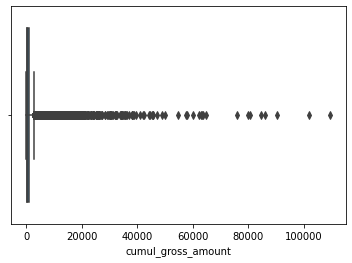

In [ ]:
sns.boxplot(X_TRAIN["cumul_gross_amount"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


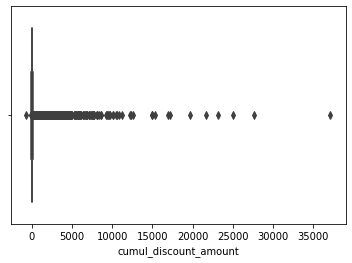

In [ ]:
sns.boxplot(X_TRAIN["cumul_discount_amount"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


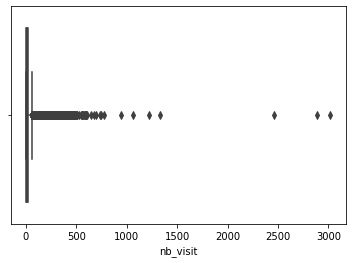

In [ ]:
sns.boxplot(X_TRAIN["nb_visit"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


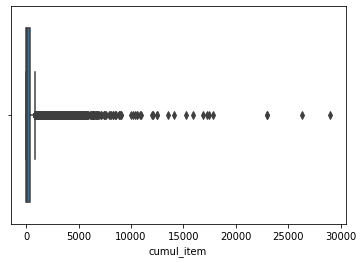

In [ ]:
sns.boxplot(X_TRAIN["cumul_item"])

There are many extreme values. 
Nevertheless, after testing removing or not the extreme values we concluded the model was better when they were ot removed. It can be explained by the presence of extreme values in the test set as well.
Thus, we do not consider the extreme values as outliers and we do not remove them.

#### **3. Creation of the table with the variable to predict in the training set**

In [ ]:
# We merge to make sure the inividuals in Y_TRAIN are the same as in X_TRAIN (in case we removed outliers)
Y_TRAIN = X_TRAIN[['id_client']].merge(TRAIN_REPURCHASE[['id_client','repurchase']], on ="id_client", how= "left")

# Index
Y_TRAIN = Y_TRAIN.set_index('id_client', drop=True)

# Check
Y_TRAIN.head()

,repurchase
id_client,
291,0
365,0
1800,1
3471,0
3961,0


In [ ]:
# Index
X_TRAIN = X_TRAIN.set_index('id_client', drop=True)
X_TRAIN

,nb_visit,cumul_item,cumul_gross_amount,cumul_discount_amount,nb_store,gift,card,cash,recency,nb_visit_2m,cumul_item_2m,cumul_gross_amount_2m,cumul_discount_amount_2m
id_client,,,,,,,,,,,,,
291,55,1499,4151.43,119.99,55,0.090909,1.000000,0.000000,0.0,9.0,231.0,638.07,3.66
365,25,140,390.05,1.97,25,0.040000,0.560000,0.440000,52.0,1.0,13.0,36.31,0.00
1800,78,1961,7900.33,879.23,78,0.269231,0.961538,0.038462,6.0,17.0,383.0,1745.92,186.05
3471,60,406,1203.76,8.53,60,0.000000,0.116667,0.883333,139.0,0.0,0.0,0.00,0.00
3961,3,131,415.34,1.62,3,0.000000,0.666667,0.333333,310.0,0.0,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88009509,7,53,128.00,12.99,7,0.000000,0.714286,0.142857,183.0,0.0,0.0,0.00,0.00
88010247,5,49,199.13,2.14,5,0.200000,1.000000,0.000000,16.0,2.0,24.0,68.28,1.19
88010368,11,256,973.93,25.83,11,0.090909,1.000000,0.000000,20.0,2.0,78.0,276.27,10.64


#### **4. Preparation of the test set**
We repeat the same preparation on the covariates for the TEST data: we need a table aggregated at the client level.

In [ ]:
TEST["transaction_date"] = TEST["transaction_date"].apply(lambda x: x[0:-14])
TEST["transaction_date"] = pd.to_datetime(TEST["transaction_date"])

# Frequency table
FREQUENCY_TEST = TEST.groupby('id_client').aggregate(
    agg_dict, drop_index=True).reset_index()

FREQUENCY_TEST.columns = col_list

# Frequency on the last 2 months
TEST_LAST_2M = TEST[TEST.transaction_date > date_last_month]

FREQUENCY_TEST_LAST_2M = TEST_LAST_2M.groupby('id_client').aggregate(
    agg_dict_last_2m, drop_index=True).reset_index()

FREQUENCY_TEST_LAST_2M.columns = col_list_last_2m

# Recency
RECENCY_TEST = TEST.groupby('id_client').aggregate(
    {'transaction_date': ['max']}).reset_index()

RECENCY_TEST.columns = ['id_client', 'last_date']
RECENCY_TEST["recency"] = (max_date - RECENCY_TEST['last_date'])/np.timedelta64(1, 'D')

# Merging
X_TEST = FREQUENCY_TEST.merge(RECENCY_TEST[['id_client','recency']], on ="id_client", how= "left")
X_TEST = X_TEST.merge(FREQUENCY_TEST_LAST_2M, on ="id_client", how= "left")

In [ ]:
# Replacing NA by 0
print(X_TEST.isna().sum())
X_TEST = X_TEST.fillna(0)
print(X_TEST.isna().sum())

id_client                       0
nb_visit                        0
cumul_item                      0
cumul_gross_amount              0
cumul_discount_amount           0
nb_store                        0
gift                            0
card                            0
cash                            0
recency                         0
nb_visit_2m                 17931
cumul_item_2m               17931
cumul_gross_amount_2m       17931
cumul_discount_amount_2m    17931
dtype: int64
id_client                   0
nb_visit                    0
cumul_item                  0
cumul_gross_amount          0
cumul_discount_amount       0
nb_store                    0
gift                        0
card                        0
cash                        0
recency                     0
nb_visit_2m                 0
cumul_item_2m               0
cumul_gross_amount_2m       0
cumul_discount_amount_2m    0
dtype: int64


In [ ]:
# Check the X_TEST table
X_TEST.head()

,id_client,nb_visit,cumul_item,cumul_gross_amount,cumul_discount_amount,nb_store,gift,card,cash,recency,nb_visit_2m,cumul_item_2m,cumul_gross_amount_2m,cumul_discount_amount_2m
0,2098,36,577,1697.54,52.98,36,0.166667,0.722222,0.194444,8.0,4.0,114.0,348.89,6.12
1,3399,103,1372,4285.57,57.11,103,0.009709,0.786408,0.077670,0.0,22.0,294.0,912.35,2.21
2,3712,80,834,2234.37,195.78,80,0.012500,0.925000,0.012500,2.0,21.0,225.0,694.27,67.48
3,4664,51,789,1996.28,50.27,51,0.039216,0.000000,0.019608,3.0,7.0,110.0,260.15,0.00
4,6741,17,391,1185.50,1.00,17,0.000000,0.058824,0.000000,142.0,0.0,0.0,0.00,0.00


In [ ]:
# Indexing
id_test = X_TEST[['id_client']]
X_TEST = X_TEST.set_index('id_client', drop=True)

There is no Y_TEST: this information is not available.

# **Step 3 : Model training (hyperparameters already tuned)**

In [ ]:
# We split the data in train and cross validation set
X_train_cv, X_CV, y_train_cv, y_CV = model_selection.train_test_split(
    X_TRAIN, Y_TRAIN, test_size=0.3)

In [ ]:
# XGBoost: run on the entire training set

xg = XGBClassifier(max_depth = 5, eta = 0.2, objective = 'binary:logistic',
                    eval_metric = 'logloss')
xg.fit(X_TRAIN, Y_TRAIN)
res1 = xg.predict_proba(X_TRAIN)

# Results: logloss and confusion matrix
print(log_loss(Y_TRAIN, res1))
predict = xg.predict(X_TRAIN)
print(confusion_matrix(Y_TRAIN, predict))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.19211747099515383
[[146993   1039]
 [ 10388   2004]]


In [ ]:
# XGBoost: run on the Cross Validation set

xg = XGBClassifier(max_depth = 3, eta = 0.2, objective = 'binary:logistic',
                    eval_metric = 'logloss', min_child_weight=3)
xg.fit(X_train_cv, y_train_cv)
res2 = xg.predict_proba(X_CV)
print(log_loss(y_CV, res2))

# Results: logloss and confusion matrix
predict = xg.predict(X_CV)
print(confusion_matrix(y_CV, predict))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.19935436115446237
[[44063   332]
 [ 3240   493]]


In [ ]:
# XGBoost: run on the test set

xg = XGBClassifier(max_depth = 5, eta = 0.2, objective = 'binary:logistic',
                    eval_metric = 'logloss')
xg.fit(X_TRAIN, Y_TRAIN)
res3 = xg.predict_proba(X_TEST)

# Predicitions for Kaggle
predict = pd.DataFrame(res3)
predict = pd.concat([id_test, predict[1]], axis=1)
predict.columns = ['id_client', 'repurchase']
predict.to_csv("Predictions.csv", index=False)
predict

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,id_client,repurchase
0,2098,0.153546
1,3399,0.426987
2,3712,0.472342
3,4664,0.202077
4,6741,0.008249
...,...,...
40101,88008276,0.007711
40102,88009039,0.009473
40103,88010326,0.039776
40104,88010343,0.006959


# **Step 4 : Tuning of the hyperparameters**
The ranges have already been reduced after different trials

Takes some time to run 

In [ ]:
# Cross validation
#param_grid_boost = {'max_depth': list(range(4,6, 1)),
                    #'eta': list(range(0.1, 0.5, 0.05)),
                    #'min_child_weight': list(range(1, 6, 1))}
#grid_boost= GridSearchCV(XGBClassifier(), param_grid_boost,cv=5)
#grid_boost.fit(X_train_cv, y_train_cv)

# Results
#print(grid_boost.best_params_)
#print(grid_boost.best_estimator_.score(X_CV, y_CV))

# **Step 5 : Analysis of the results**
Our goal is to identity the clients who are most likely to buy back soon: so we need to identify them and then to describe them

#### **1. Cumulative Gain Curve**
As we do not know the true value of the varables to redict in the test set, we will use the predictions used in cross validation.

<Figure size 1440x1440 with 0 Axes>

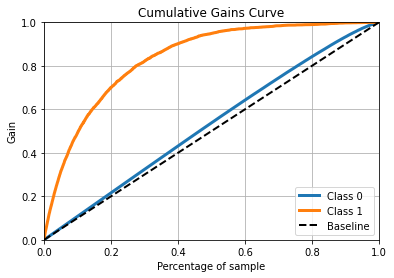

In [ ]:
plt.figure(figsize=(20,20))
skplt.metrics.plot_cumulative_gain(y_CV, res2)
plt.show()

#### **2. Descriptive statistics of the 10% who are most likely to buy back the next month**

In [ ]:
# Merge the covariates and the predictions
target = X_TEST.merge(predict, on ="id_client", how= "left")
target

,id_client,nb_visit,cumul_item,cumul_gross_amount,cumul_discount_amount,nb_store,gift,card,cash,recency,nb_visit_2m,cumul_item_2m,cumul_gross_amount_2m,cumul_discount_amount_2m,repurchase
0,2098,36,577,1697.54,52.98,36,0.166667,0.722222,0.194444,8.0,4.0,114.0,348.89,6.12,0.153546
1,3399,103,1372,4285.57,57.11,103,0.009709,0.786408,0.077670,0.0,22.0,294.0,912.35,2.21,0.426987
2,3712,80,834,2234.37,195.78,80,0.012500,0.925000,0.012500,2.0,21.0,225.0,694.27,67.48,0.472342
3,4664,51,789,1996.28,50.27,51,0.039216,0.000000,0.019608,3.0,7.0,110.0,260.15,0.00,0.202077
4,6741,17,391,1185.50,1.00,17,0.000000,0.058824,0.000000,142.0,0.0,0.0,0.00,0.00,0.008249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40101,88008276,2,12,44.01,0.00,2,0.000000,1.000000,0.000000,101.0,0.0,0.0,0.00,0.00,0.007711
40102,88009039,14,94,350.20,7.28,14,0.000000,1.000000,0.000000,138.0,0.0,0.0,0.00,0.00,0.009473
40103,88010326,15,141,420.18,31.18,15,0.000000,0.533333,0.000000,55.0,1.0,6.0,29.36,0.00,0.039776
40104,88010343,4,39,107.12,0.68,4,0.000000,1.000000,0.000000,240.0,0.0,0.0,0.00,0.00,0.006959


In [ ]:
# Sort the predictions to easily identify the clients who are most likely to repurchase next month
target_sort = target.sort_values(by='repurchase', ascending=False)

In [ ]:
# Data frame with the 10 %
ten_percent = target_sort.iloc[:4010,:]
ten_percent.describe()

,id_client,nb_visit,cumul_item,cumul_gross_amount,cumul_discount_amount,nb_store,gift,card,cash,recency,nb_visit_2m,cumul_item_2m,cumul_gross_amount_2m,cumul_discount_amount_2m,repurchase
count,4.010000e+03,4010.000000,4010.000000,4010.000000,4010.000000,4010.000000,4010.000000,4010.000000,4010.000000,4010.000000,4010.000000,4010.000000,4010.000000,4010.000000,4010.000000
mean,3.457716e+07,85.975062,1303.288030,4055.474182,360.012638,85.975062,0.076523,0.693926,0.212805,3.587282,16.138653,245.545636,757.072195,66.341591,0.379065
std,2.871782e+07,76.386206,1097.324414,4597.018203,918.427905,76.386206,0.094454,0.319148,0.280135,3.382712,13.064578,264.498706,803.348793,198.876045,0.138840
min,3.399000e+03,6.000000,45.000000,59.870000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,3.000000,17.000000,21.150000,0.000000,0.212884
25%,1.058216e+07,50.000000,619.000000,1743.335000,30.755000,50.000000,0.009091,0.470588,0.013986,1.000000,10.000000,114.000000,323.062500,2.235000,0.266552
50%,3.068936e+07,71.000000,1068.000000,3146.535000,129.015000,71.000000,0.044444,0.827586,0.079287,3.000000,13.000000,193.000000,567.840000,14.930000,0.340260
75%,3.881380e+07,102.000000,1729.000000,5272.425000,388.467500,102.000000,0.111111,0.961538,0.312500,6.000000,18.000000,310.000000,968.890000,61.317500,0.463897
max,8.800787e+07,2895.000000,19873.000000,153105.660000,29219.420000,2895.000000,0.664452,1.000000,1.000000,27.000000,397.000000,7897.000000,14717.700000,5529.380000,0.876049


We can see  the 10% with the highest propensity score, and the target population for the campaign. We can also see that the majority of them in our model have a score inferior to 0.5. Thus usual classification with a bandwith of 0.5 would have given us fewer individuals. This could partially be a result of the severe class imbalance in our model.